In [1]:
# import packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.stats as sms
import statsmodels.stats.api as smss
from scipy import stats
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import itertools

warnings.filterwarnings('ignore')

C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(y_scores,p, r, thresholds, t= 0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    
    # plot the curve
    sns.set()
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.0, 1.00])
    plt.xlim([0.0, 1.00])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

def adjust_probabilities(y_scores, b):
    a = (1-b)
    y_scores = (a*(y_scores)-a*b*(y_scores))/(a*(y_scores)+b+b*y_scores-a*b)
    return y_scores

In [3]:
# import data
df = pd.read_csv('BGVSpringboardData.csv')

In [4]:
#Set TourID to index
df= df.set_index('TourID_dimension')




# remove outliers:
print(len(df))
pU, pL = np.percentile(df['?TourGeneration'], [99.85 ,0.15])
df = df.loc[df['?TourGeneration'] <= (pU)]
df = df.loc[df['?TourGeneration'] >= (pL)]
print(len(df))
pU, pL = np.percentile(df['TourContractGeneration'], [99.85 ,0.15])
df = df.loc[df['TourContractGeneration'] <= (pU)]
df = df.loc[df['TourContractGeneration'] >= (pL)]
print(len(df))


# create dictionary to change binary categorical output variable to an integer
dic = {'Sale':1,'No Sale':0}
dic1 = {'Yes':1,'No':0}
dic2 = {'In State':1,'Out of State':0}
dic3 = {'Owner':1,'1st Gen':0}
dic4 = {'Couple':1,'Single':0}
dic5 = {'Weekday':0, 'Weekend':1}
dic6 = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
dic7 = {2016:0, 2017:1, 2018:2}

# convert binary categorical output variable to integer values ) and 1
df['ResultOfTour']=df['ResultOfTour'].replace(dic)
df['Homeowner']=df['Homeowner'].replace(dic1)
df['InState']=df['InState'].replace(dic2)
df['FirstGenVsOwner']=df['FirstGenVsOwner'].replace(dic3)
df['relationStatus']=df['relationStatus'].replace(dic4)
df['WeekdayOrWeekend']=df['WeekdayOrWeekend'].replace(dic5)
df['Month of TourDate']=df['Month of TourDate'].replace(dic6)
df['Year of TourDate']=df['Year of TourDate'].replace(dic7)


print(df.info())

25777
25746
25710
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25710 entries, 109662 to 385812
Data columns (total 17 columns):
?TourGeneration               25710 non-null int64
Age                           25710 non-null int64
AgentLine                     25710 non-null object
BookingWindow                 25710 non-null object
FirstGenVsOwner               25710 non-null int64
HHIncomeRanges                25710 non-null object
Homeowner                     25710 non-null int64
InState                       25710 non-null int64
Month of TourDate             25710 non-null int64
Programs (Budget)             25710 non-null object
relationStatus                25710 non-null int64
ResultOfTour                  25710 non-null int64
TourContractGeneration        25710 non-null int64
TourSeason                    25710 non-null object
WeekdayOrWeekend              25710 non-null int64
Year of TourDate              25710 non-null int64
NetVolumePlusNonGoodVolume    25710 non-null f

In [5]:
dfX = df.drop(['ResultOfTour',  'NetVolumePlusNonGoodVolume'], axis = 1)
dfX = pd.get_dummies(dfX, prefix=[ 'AgentLine','BookingWindow','HHIncomeRanges','Programs (Budget)', 'TourSeason'])
                                  
scaler1 = StandardScaler()
scaler1.fit(dfX[['Age']])
dfX['Age'] = scaler1.transform(dfX[['Age']])     


scaler2 = StandardScaler()
scaler2.fit(dfX[['TourContractGeneration']])
dfX['TourContractGeneration'] = scaler2.transform(dfX[['TourContractGeneration']])

scaler3 = StandardScaler()
scaler3.fit(dfX[['?TourGeneration']])
dfX['?TourGeneration'] = scaler3.transform(dfX[['?TourGeneration']])


X_train, X_test, y_train, y_test = train_test_split(dfX, df['ResultOfTour'], stratify=df['ResultOfTour'], test_size=0.2,random_state = 42)

dfX1 = X_train
dfY1 = y_train
 
print(dfX1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20568 entries, 341314 to 331921
Data columns (total 43 columns):
?TourGeneration                                20568 non-null float64
Age                                            20568 non-null float64
FirstGenVsOwner                                20568 non-null int64
Homeowner                                      20568 non-null int64
InState                                        20568 non-null int64
Month of TourDate                              20568 non-null int64
relationStatus                                 20568 non-null int64
TourContractGeneration                         20568 non-null float64
WeekdayOrWeekend                               20568 non-null int64
Year of TourDate                               20568 non-null int64
AgentLine_Breck                                20568 non-null uint8
AgentLine_Colorado                             20568 non-null uint8
AgentLine_Other Line                           20568 non-null u

In [6]:
bestC = 0
bestTLR = 0
bestF1LR = 0
bestF1C = 0
bestCMLR = pd.DataFrame()
i = 0
colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
Cs = [0.01, 0.1, 1,10,50]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



for train, test in kf.split(dfX1,dfY1):
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTest = dfX1.iloc[test.tolist()]
    yTest = dfY1.iloc[test.tolist()]
    lr = LogisticRegression(C=Cs[i], fit_intercept=False)
    lr.fit(xTrain,yTrain)
    preds = lr.predict_proba(xTest)[:,1]
    for j in preds:
        predT = adjusted_classes(preds, j)
        f1 = metrics.fbeta_score(yTest, predT,beta = 2,average='binary')
        if f1>bestF1LR:
            bestC=Cs[i]
            bestF1LR=f1
            bestTLR= j
            bestCMLR =pd.DataFrame(confusion_matrix(yTest, predT),
                                columns=['pred_neg', 'pred_pos'], 
                                index=['neg', 'pos'])
    i += 1
    
print(bestC)
print(bestTLR)
print(bestF1LR)
print(bestCMLR)

0.1
0.13227105277339243
0.5577562985263825
     pred_neg  pred_pos
neg       835      2503
pos        72       704


In [7]:
bestL = 0
bestSs = 0
bestD = 0
bestTRFC = 0
bestF1RFC = 0
bestCMRFC = pd.DataFrame()
i = 0
k = 0
h = 0

#make cross validation of c values and kfold
Ls = [1,20,40, 80,100]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



for train, test in kf.split(dfX1,dfY1):
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTest = dfX1.iloc[test.tolist()]
    yTest = dfY1.iloc[test.tolist()]
    rfc = RandomForestClassifier(n_estimators=1000, random_state=42, min_samples_leaf =Ls[i])
    rfc.fit(xTrain,yTrain)
    preds = rfc.predict_proba(xTest)[:,1]
    for j in preds:
        predT = adjusted_classes(preds, j)
        f1 = metrics.fbeta_score(yTest, predT,beta=2,average='binary')
        if f1>bestF1RFC:
            bestL=Ls[i]
            bestF1RFC=f1
            bestTRFC= j
            bestCMRFC = pd.DataFrame(confusion_matrix(yTest, predT),
                                columns=['pred_neg', 'pred_pos'], 
                                index=['neg', 'pos'])
    i += 1

        
print(bestL)
print(bestTRFC)
print(bestF1RFC)
print(bestCMRFC)

100
0.14726359245514212
0.5582149474984558
     pred_neg  pred_pos
neg       685      2653
pos        52       723


In [8]:
bestCMHL = pd.DataFrame()
bestHL = 0
bestF1HL = 0
bestTHL =0
i = 0

#make cross validation of c values and kfold
HLs= [x for x in itertools.product((2,4,10,20,40),repeat=1)]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



for train, test in kf.split(dfX1,dfY1):
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTest = dfX1.iloc[test.tolist()]
    yTest = dfY1.iloc[test.tolist()]
    mlp = MLPClassifier(hidden_layer_sizes=HLs[i])
    mlp.fit(xTrain,yTrain)
    preds = mlp.predict_proba(xTest)[:,1]
    for j in preds:
        predT = adjusted_classes(preds, j)
        f1 = metrics.fbeta_score(yTest, predT,beta=2,average='binary')
        if f1>bestF1HL:
            bestHL=HLs[i]
            bestF1HL=f1
            bestTHL= j
            bestCMHL = pd.DataFrame(confusion_matrix(yTest, predT),
                                columns=['pred_neg', 'pred_pos'], 
                                index=['neg', 'pos'])
    i += 1

print(bestHL)
print(bestTHL)
print(bestF1HL)
print(bestCMHL)

(4,)
0.11131144662610709
0.5605871330418489
     pred_neg  pred_pos
neg       756      2582
pos        58       718


Logistic Regression Threshold: 0.13227105277339243
     pred_neg  pred_pos
neg       971      3201
pos        92       878
Best F2 Score:  0.552


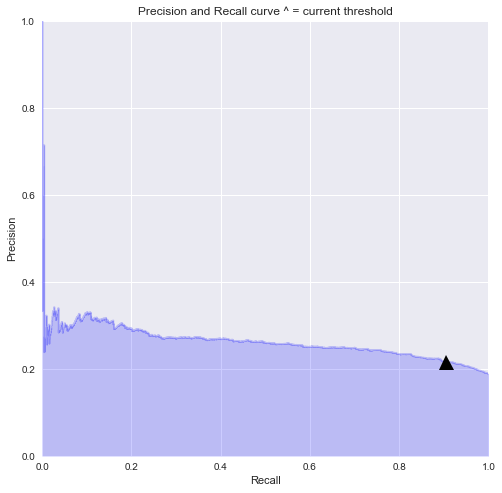

In [9]:
lr= LogisticRegression(C = bestC, fit_intercept=False)
lr.fit(dfX1,dfY1)
y_scores = lr.predict_proba(X_test)[:, 1]
p,r,threshold = precision_recall_curve(y_test,y_scores)
precision_recall_threshold(y_scores ,p, r, threshold, bestTLR)
y_scores = adjusted_classes(y_scores,bestTLR)
print('Logistic Regression Threshold:',str(bestTLR))
print(pd.DataFrame(confusion_matrix(y_test, y_scores),
                    columns=['pred_neg', 'pred_pos'], 
                    index=['neg', 'pos']))
print('Best F2 Score: ',str(round(metrics.fbeta_score(y_test,y_scores,average='binary', beta =2),3)))

Random Forest Threshold: 0.14726359245514212
     pred_neg  pred_pos
neg       945      3227
pos        84       886
Best F2 Score:  0.554


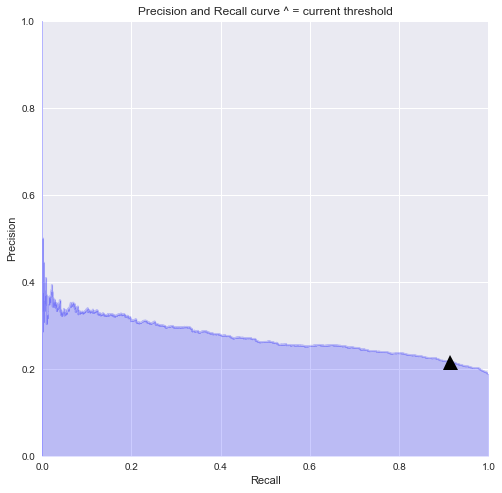

In [10]:
rf= RandomForestClassifier(n_estimators=1000, random_state=42, min_samples_leaf =bestL)
rf.fit(dfX1,dfY1)
y_scores = rf.predict_proba(X_test)[:, 1]
p,r,threshold = precision_recall_curve(y_test,y_scores)
precision_recall_threshold(y_scores ,p, r, threshold, bestTRFC)
y_scores = adjusted_classes(y_scores,bestTRFC)
print('Random Forest Threshold:',str(bestTRFC))
print(pd.DataFrame(confusion_matrix(y_test, y_scores),
                    columns=['pred_neg', 'pred_pos'], 
                    index=['neg', 'pos']))
print('Best F2 Score: ',str(round(metrics.fbeta_score(y_test,y_scores,average='binary', beta =2),3)))

MLP Best Threshold: 0.11131144662610709
     pred_neg  pred_pos
neg       836      3336
pos        69       901
Best F2 Score:  0.555


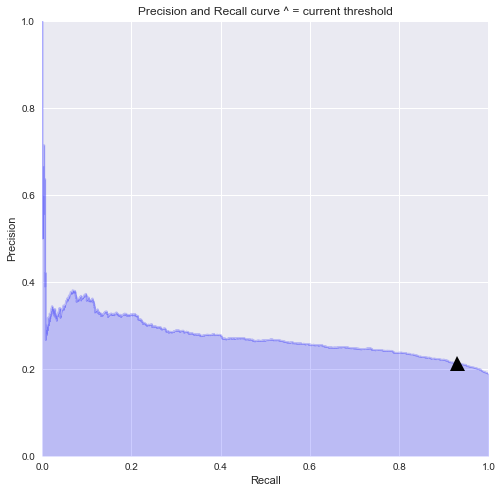

In [11]:
mlp = MLPClassifier(hidden_layer_sizes=bestHL)
mlp.fit(dfX1,dfY1)
y_scores = mlp.predict_proba(X_test)[:,1]
p,r,threshold = precision_recall_curve(y_test,y_scores)
precision_recall_threshold(y_scores ,p, r, threshold, bestTHL)
y_scores = adjusted_classes(y_scores,bestTHL)
print('MLP Best Threshold:',str(bestTHL))
print(pd.DataFrame(confusion_matrix(y_test, y_scores),
                    columns=['pred_neg', 'pred_pos'], 
                    index=['neg', 'pos']))
print('Best F2 Score: ',str(round(metrics.fbeta_score(y_test,y_scores,average='binary',beta =2),3)))

In [12]:
for x,y in sorted(zip(rf.feature_importances_, X_test.columns.tolist()), reverse =True):
    print(round(x,3),'\t',y)

0.14 	 ?TourGeneration
0.11 	 Age
0.106 	 TourContractGeneration
0.098 	 InState
0.068 	 FirstGenVsOwner
0.052 	 HHIncomeRanges_70k to 89k
0.045 	 Month of TourDate
0.025 	 Year of TourDate
0.024 	 AgentLine_Colorado
0.023 	 HHIncomeRanges_200k to 349k
0.022 	 WeekdayOrWeekend
0.021 	 HHIncomeRanges_150k to 199k
0.021 	 AgentLine_Breck
0.02 	 Programs (Budget)_(12) Outbound Telemarktng
0.018 	 HHIncomeRanges_90k to 149k
0.018 	 Programs (Budget)_(09) GL7 Inhouse
0.017 	 BookingWindow_Inside 90 days
0.016 	 HHIncomeRanges_Under 70k
0.015 	 Programs (Budget)_(21) GTL In House
0.014 	 BookingWindow_Inside 2 Days
0.014 	 TourSeason_Spring
0.01 	 TourSeason_Winter
0.009 	 BookingWindow_Inside Year
0.009 	 Programs (Budget)_(15) Internet
0.008 	 BookingWindow_Inside Week
0.008 	 TourSeason_Summer
0.007 	 BookingWindow_Inside Month
0.007 	 HHIncomeRanges_350k to 500k
0.007 	 relationStatus
0.007 	 Programs (Budget)_(17) Guest Member
0.007 	 Programs (Budget)_(06) GC8 Inhouse
0.006 	 BookingWi

In [13]:

for coef, feat in sorted(zip(lr.coef_[0], X_test.columns.tolist()), reverse = True):
    print(round(coef,3),'\t',feat )

0.482 	 FirstGenVsOwner
0.415 	 TourContractGeneration
0.345 	 Programs (Budget)_(17) Guest Member
0.316 	 InState
0.052 	 relationStatus
0.043 	 Age
0.023 	 Programs (Budget)_(24) Front Range Events
0.004 	 Programs (Budget)_(12) Outbound Telemarktng
0.001 	 HHIncomeRanges_350k to 500k
0.001 	 WeekdayOrWeekend
-0.003 	 Month of TourDate
-0.03 	 HHIncomeRanges_Over 500k
-0.086 	 Homeowner
-0.09 	 Year of TourDate
-0.097 	 HHIncomeRanges_200k to 349k
-0.125 	 Programs (Budget)_(06) GC8 Inhouse
-0.138 	 Programs (Budget)_(14) Summit County OPC
-0.143 	 Programs (Budget)_(09) GL7 Inhouse
-0.146 	 Programs (Budget)_(16) Outbound Referral
-0.165 	 HHIncomeRanges_150k to 199k
-0.206 	 BookingWindow_Inside Week
-0.213 	 BookingWindow_Inside Year
-0.241 	 Programs (Budget)_(28) Inbound Referral
-0.249 	 BookingWindow_Inside Half Year
-0.251 	 BookingWindow_Inside Month
-0.305 	 BookingWindow_Inside 90 days
-0.315 	 BookingWindow_Over a Year
-0.321 	 Programs (Budget)_(21) GTL In House
-0.321 	